# Sentiment analysis
### Machine learning course project
#### Marta Kałużna, Szymon Czop

JAKIŚ ŁADNY WSTĘPIK

Sentiment analysis is a common NLP task........
Krótki opis czym się zajmujemy (sentiment analysis) i opis bazy danych. Jakich metody używamy. 

In [15]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

### Functions for data cleaning

In [16]:
import nltk 
import string
import re
from nltk.corpus import stopwords

ps = nltk.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove punctuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [17]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

### Loading Dataset

In [18]:
df = pd.read_csv("IMDB_sample.csv")
df.shape

(7501, 3)

In [19]:

df.head() # 1 positive, 0 negative

Unnamed: 0                                             review  label
0       18245  This short spoof can be found on Elite's Mille...      0
1       19801  A singularly unfunny musical comedy that artif...      0
2        3222  An excellent series, masterfully acted and dir...      1
3        6010  The master of movie spectacle Cecil B. De Mill...      1
4       16355  I was gifted with this movie as it had such a ...      0

In [20]:
df.label.value_counts()

0    3782
1    3719
Name: label, dtype: int64

### Cleaning Data

In [21]:
clean_texts = []
for i in range(0, df.shape[0]):                                                                    
    clean_texts.append(cleaner(df['review'][i]))

In [22]:
clean_df = pd.DataFrame(clean_texts, columns = ['text'])
clean_df.head()

text
0  this short spoof can be found on elite millenn...
1  singularly unfunny musical comedy that artific...
2  an excellent series masterfully acted and dire...
3  the master of movie spectacle cecil de mille g...
4  was gifted with this movie as it had such grea...

In [23]:
clean_df["text2"] = df['review'].apply(lambda x : clean_text(x))

In [24]:
clean_df['target'] = df.label
clean_df.head()
# cleaner, clean_text

text  \
0  this short spoof can be found on elite millenn...   
1  singularly unfunny musical comedy that artific...   
2  an excellent series masterfully acted and dire...   
3  the master of movie spectacle cecil de mille g...   
4  was gifted with this movie as it had such grea...   

                                               text2  target  
0  [short, spoof, found, elit, millennium, edit, ...       0  
1  [singularli, unfunni, music, comedi, artifici,...       0  
2  [excel, seri, master, act, direct, unlov, told...       1  
3  [master, movi, spectacl, cecil, b, de, mill, g...       1  
4  [gift, movi, great, premis, friendship, three,...       0

porównanie dwóch sposobów czyszczenia

In [23]:
#clean_df.to_csv('clean_imdb.csv',encoding='utf-8')

##### Checking for NA values 

In [45]:
clean_df.info()
clean_df[clean_df.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 3 columns):
text      7501 non-null object
text2     7501 non-null object
target    7501 non-null int64
dtypes: int64(1), object(2)
memory usage: 175.9+ KB


Empty DataFrame
Columns: [text, text2, target]
Index: []

### Creating wordcloud

In [46]:
from wordcloud import WordCloud

#### Negative wordcloud

In [48]:
neg_rev = clean_df[clean_df.target == 0]
neg_string = []
for t in neg_rev.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep = ' ')

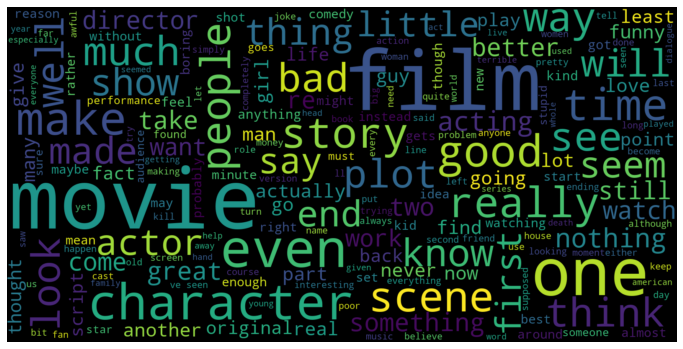

In [49]:
wordcloud = WordCloud(width = 1600, height = 800, max_font_size = 200).generate(neg_string)
plt.figure(figsize = (12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('first_negative.png')
plt.show()

#### Positive wordcloud

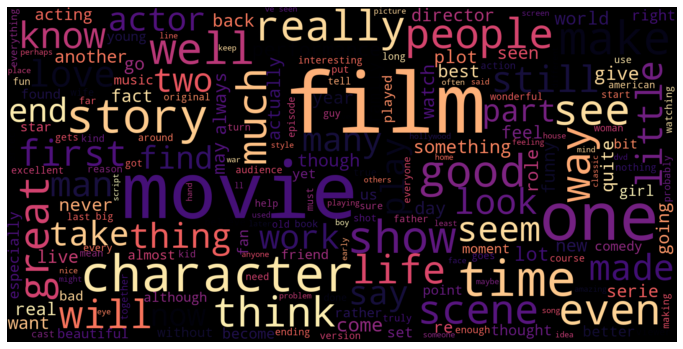

In [50]:
pos_rev = clean_df[clean_df.target == 1]
pos_string = []
for t in pos_rev.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width = 1600, height = 800, max_font_size = 200, colormap = 'magma').generate(pos_string) 
plt.figure(figsize = (12,10)) 
plt.imshow(wordcloud, interpolation = "bilinear") 
plt.axis("off") 
plt.savefig('first_positive.png')
plt.show()

### Ratio between positives and negatives

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

In [53]:
countVectorizer = CountVectorizer() 
countVectorizer2 = CountVectorizer(analyzer = clean_text) 

countVector = countVectorizer.fit_transform(clean_df['text'])
countVector2 = countVectorizer2.fit_transform(clean_df['text'])

In [54]:
[countVector.shape,countVector2.shape]

[(7501, 45032), (7501, 30279)]

In [55]:
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [56]:
matrix = countVector.toarray()

neg_matrix = matrix[clean_df.target == 0]
pos_matrix = matrix[clean_df.target == 1]

neg_tf = np.sum(neg_matrix, axis = 0)
pos_tf = np.sum(pos_matrix, axis = 0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

In [61]:
term_freq_df = pd.DataFrame([neg, pos], columns = countVectorizer.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by = 'total', ascending=False).iloc[:10]

negative  positive   total
the      48519     52181  100700
and      22202     26871   49073
of       20430     22867   43297
to       20412     20165   40577
is       15230     17671   32901
it       14435     14487   28922
in       12973     15283   28256
this     12199     10760   22959
that     11354     10909   22263
not      10783      8447   19230

In [65]:
matrix = countVector2.toarray()

neg_matrix = matrix[clean_df.target == 0]
pos_matrix = matrix[clean_df.target == 1]

neg_tf = np.sum(neg_matrix,axis=0)
pos_tf = np.sum(pos_matrix,axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df2 = pd.DataFrame([neg,pos], columns=countVectorizer2.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by = 'total', ascending=False).iloc[:10]

negative  positive  total
movi         8695      6907  15602
film         6864      7684  14548
one          4054      4316   8370
like         3685      3202   6887
time         2256      2502   4758
good         2202      2427   4629
make         2418      2134   4552
see          2011      2328   4339
get          2364      1967   4331
charact      2167      2136   4303

In [66]:
multi_table([term_freq_df.sort_values(by='total', ascending=False).iloc[:10],term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]])

As a comparison, we've considered two approaches to CountVectorizer: 1st - with less cleaned data, 2nd - data has been cleaned using a 'clean_text' function. We've printed 10 most common used words for those two methods. At first glance, we can notice that every word has almost the same number of negative and positive representations. But in 'non-cleaned' data, these words doesn't make sense in case of sentiment analysis.

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency (cleaned data)')

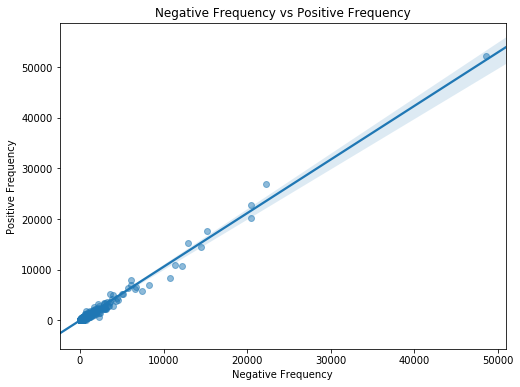

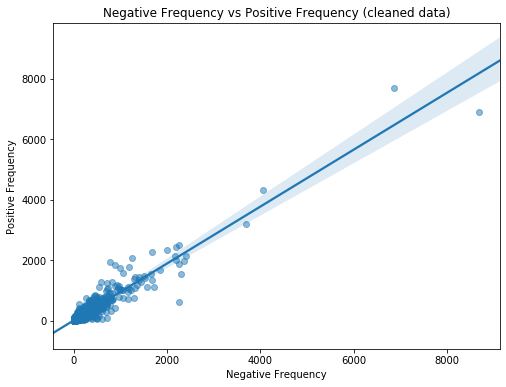

In [74]:
import seaborn as sns 

plt.figure(figsize=(8,6))
ax = sns.regplot(x = "negative", y = "positive", fit_reg = True, scatter_kws = {'alpha': 0.5}, data = term_freq_df)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=True, scatter_kws={'alpha': 0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency (cleaned data)')

Plots just confirmed what we noticed above. The negative frequency of the words is almost the same as the positive one - especially when data is not cleaned. Most of the words are below 10000 on the first plot and below 2000 on the second one. From the second plot, we can remark that now there are more points which occur more often as a positive/negative word -> situation changes (for better, in case of sentiment analysis) when we clean the data.

## Zipf's law

OPIS - SZYMEK

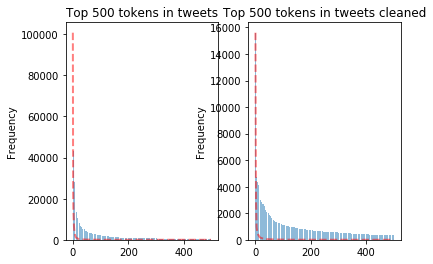

In [70]:
y_pos = np.arange(500)

plt.subplot(121)
expected_zipf = [term_freq_df.sort_values(by = 'total', ascending=False)['total'][i]/(i+1) for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by = 'total', ascending = False)['total'][:500], align = 'center', alpha = 0.5)
plt.plot(y_pos, expected_zipf, color = 'r', linestyle = '--', linewidth = 2, alpha = 0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')


plt.subplot(122)
expected_zipf = [term_freq_df2.sort_values(by = 'total', ascending = False)['total'][i]/(i+1) for i in y_pos]
plt.bar(y_pos, term_freq_df2.sort_values(by = 'total', ascending = False)['total'][:500], align = 'center', alpha = 0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--', linewidth = 2, alpha = 0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets cleaned')
plt.show()


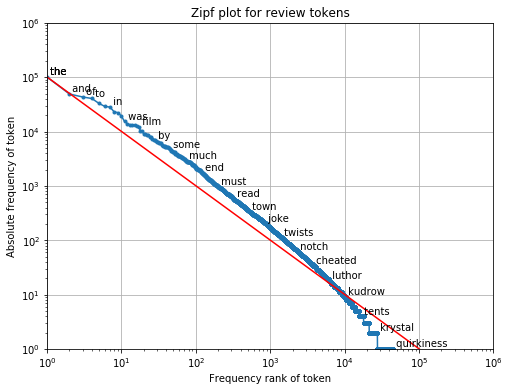

In [68]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index

ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize = (8,6))
plt.ylim(1, 10**6)
plt.xlim(1, 10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1, frequencies[0]], [frequencies[0], 1], color = 'r')
title("Zipf plot for review tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)

for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment = "bottom",
                 horizontalalignment = "left")

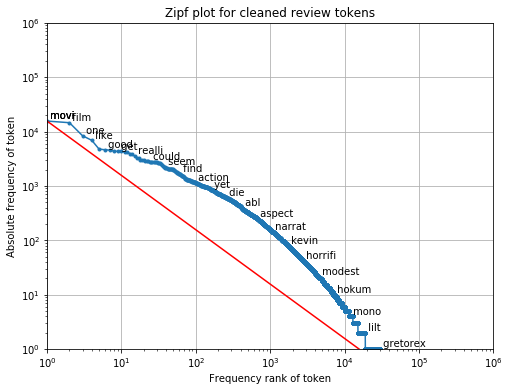

In [72]:
counts = term_freq_df2.total
tokens = term_freq_df2.index

ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for cleaned review tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

### Some statistics

In [75]:
import statsmodels.api as sm
    
X = sm.add_constant(term_freq_df.negative.values)    
mod = sm.OLS(term_freq_df.positive.values,X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 3.269e+06
Date:                Wed, 29 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:32:54   Log-Likelihood:            -2.3397e+05
No. Observations:               45032   AIC:                         4.679e+05
Df Residuals:                   45030   BIC:                         4.680e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2738      0.206     -1.329      0.184      -0.678       0.130
x1             1.0583      0.001   1807.962      0.000       1.057       1.059
==============================================================================
Omnibus:                    52657.474   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       6761997908.725
Skew:                          -4.249   Prob(JB):                         0.00
Kurtosis:                    1901.358   Cond. No.                         353.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the summary, we can note that R-squared statistics is almost 1, which in fact means that our data is really close to the fitted regression line. 

In [76]:
X = sm.add_constant(term_freq_df2.negative.values)    
mod = sm.OLS(term_freq_df2.positive.values,X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 3.344e+05
Date:                Wed, 29 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:33:22   Log-Likelihood:            -1.4554e+05
No. Observations:               30279   AIC:                         2.911e+05
Df Residuals:                   30277   BIC:                         2.911e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6529      0.172      9.626      0.000       1.316       1.990
x1             0.9414      0.002    578.299      0.000       0.938       0.945
==============================================================================
Omnibus:                    24712.680   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        647864364.706
Skew:                           2.043   Prob(JB):                         0.00
Kurtosis:                     719.589   Cond. No.                         106.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Similar results: R-squared is lower than earlier, but still high. 
#Summary: Cleaning the data (tokenization, stemming, removing stopwords and punctuation) is helpful.

# Further calculation of the rates (more advanced)

In this section, we're going to calculate different rates to find any dependencies.

In [77]:
term_freq_df.head()

negative  positive  total
aa                  1         1      2
aaa                 1         2      3
aaaaah              1         0      1
aaaahhhhhhh         1         0      1
aaah                1         0      1

In [78]:
from scipy.stats import hmean
from scipy.stats import norm

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

In [79]:
#pos_rate = positive_frequancy/(positive + negative) 
term_freq_df['pos_rate'] = term_freq_df['positive'] /term_freq_df['total']
term_freq_df['neg_rate'] = term_freq_df['negative'] /term_freq_df['total']
# positive/sum(positive)
term_freq_df['pos_freq_pct'] = term_freq_df['positive'] /term_freq_df['positive'].sum()
term_freq_df['neg_freq_pct'] = term_freq_df['negative'] /term_freq_df['negative'].sum()
#harmonic mean
term_freq_df['pos_hmean'] = term_freq_df.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
term_freq_df['neg_hmean'] = term_freq_df.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 else 0), axis=1)
#norm cdf 
term_freq_df['pos_rate_normcdf'] = normcdf(term_freq_df['pos_rate'])
term_freq_df['pos_freq_pct_normcdf'] = normcdf(term_freq_df['pos_freq_pct'])
term_freq_df['pos_normcdf_hmean'] = hmean([term_freq_df['pos_rate_normcdf'], term_freq_df['pos_freq_pct_normcdf']])
term_freq_df['neg_rate_normcdf'] = normcdf(term_freq_df['neg_rate'])
term_freq_df['neg_freq_pct_normcdf'] = normcdf(term_freq_df['neg_freq_pct'])
term_freq_df['neg_normcdf_hmean'] = hmean([term_freq_df['neg_rate_normcdf'], term_freq_df['neg_freq_pct_normcdf']])

term_freq_df2['pos_rate'] = term_freq_df2['positive'] /term_freq_df2['total']
term_freq_df2['neg_rate'] = term_freq_df2['negative'] /term_freq_df2['total']
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] /term_freq_df2['positive'].sum()
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] /term_freq_df2['negative'].sum()
term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 else 0), axis=1)
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])


multi_table([term_freq_df.sort_values(by='pos_freq_pct', ascending=False).iloc[:10],term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]])

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

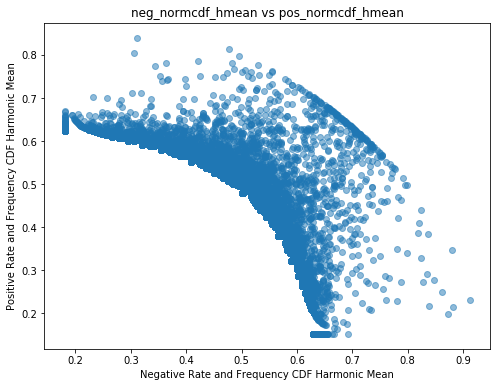

In [80]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

Plot of the harmonic mean of rate CDF and frequency CDF (for less cleaned data).    
If a point is closer to the upper left corner, it is more positive, and if it is closer to the bottom right corner, it is more negative.

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

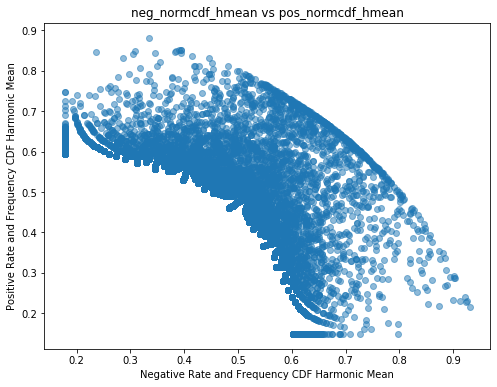

In [81]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

Plot of the harmonic mean of rate CDF and frequency CDF (for cleaned data).    
In both cases, it has created an interesting, almost symmetrical shape.

In [82]:
from bokeh.plotting import figure,output_file,show
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

In [83]:
output_notebook()

Loading BokehJS ...

In [84]:
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df.pos_normcdf_hmean), high=max(term_freq_df.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

The brighter the data point, the more positive is a word.

## Testing models on our dataset

In [162]:
clean_df.columns
#clean_df.shape #(7501,3)

Index(['text', 'text2', 'target'], dtype='object')

In [163]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.model_selection import train_test_split

In [165]:
x = clean_df.text
y = clean_df.target

SEED = 2020
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
print(f"Train test has {len(x_train)} etries where negative are {(len(x_train[y_train == 0])/len(x_train)) * 100}% \n and positive {(len(x_train[y_train == 1])/len(x_train)) * 100}% \n")
print(f"Test set has {len(x_test)} etries where negative are {(len(x_test[y_test== 0])/len(x_test)) * 100}% \n and positive {(len(x_test[y_test== 1])/len(x_test)) * 100}% \n")


Train test has 6000 etries where negative are 50.66666666666667% 
 and positive 49.333333333333336% 

Test set has 1501 etries where negative are 49.43371085942705% 
 and positive 50.56628914057295% 



We divided our dataset into the train and test set (in proportions 80:20). In both sets, there are about 50% of negative words and 50% of positive words.

In [174]:
def accuracy(pipeline,x_train,y_train,x_test,y_test):
    
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    #accuracy_train = pipeline.score(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy on test data {accuracy} \n")
    
    print(f"train and test time {train_test_time } ")
    print("-"*85)
    return accuracy, train_test_time

In [167]:
countVectorizer = CountVectorizer() 
countVectorizer2 = CountVectorizer(analyzer = clean_text) 
countVector = countVectorizer.fit_transform(clean_df['text'])
countVector2 = countVectorizer2.fit_transform(clean_df['text'])
lr = LogisticRegression()

In [170]:
[len(countVectorizer.get_feature_names()),len(countVectorizer2.get_feature_names())]

[45032, 30279]

In [179]:
n_features = np.arange(5000,30001,2500)
def nfeature_accuracy_checker(vectorizer=countVectorizer, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr,analyzer = 'word'):
    
    result = []
    print(classifier,'\n')
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range,analyzer = analyzer)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        nfeature_accuracy,tt_time = accuracy(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    
    return result 

In [180]:
feat_tun_nochanges = nfeature_accuracy_checker()
feat_tun_nochanges_df = pd.DataFrame(feat_tun_nochanges,columns =['nfeatures','validation_accuracy','train_test_time'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Accuracy on test data 0.8374417055296469 

train and test time 2.810873031616211 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8421052631578947 

train and test time 2.6468098163604736 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8414390406395736 

train and test time 4.064258098602295 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8454363757495004 

train and test time 2.719153881072998 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8461025982678214 

train and test tim

In [181]:
feat_tun_stop_words = nfeature_accuracy_checker(stop_words='english')
feat_tun_stop_words_df = pd.DataFrame(feat_tun_stop_words,columns =['nfeatures','validation_accuracy','train_test_time'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Accuracy on test data 0.8414390406395736 

train and test time 1.9752552509307861 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8381079280479681 

train and test time 2.1429789066314697 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8427714856762158 

train and test time 1.8485469818115234 
-------------------------------------------------------------------------------------
Accuracy on test data 0.844103930712858 

train and test time 2.06129789352417 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8481012658227848 

train and test tim

In [182]:
feat_tun_full_clean= nfeature_accuracy_checker(analyzer = clean_text)
feat_tun_full_clean_df = pd.DataFrame(feat_tun_full_clean,columns =['nfeatures','validation_accuracy','train_test_time'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Accuracy on test data 0.8381079280479681 

train and test time 31.85361623764038 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8361092604930047 

train and test time 30.435130834579468 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8414390406395736 

train and test time 30.51500105857849 
-------------------------------------------------------------------------------------
Accuracy on test data 0.843437708194537 

train and test time 31.04067087173462 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8461025982678214 

train and test time

### Logistic regression + unigram

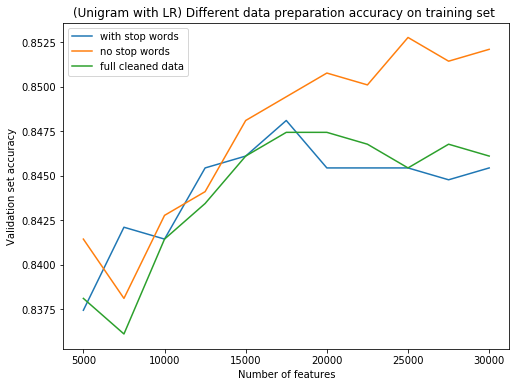

In [207]:
plt.figure(figsize=(8,6))
plt.plot(feat_tun_nochanges_df.nfeatures,feat_tun_nochanges_df.validation_accuracy,label = 'with stop words')
plt.plot(feat_tun_stop_words_df.nfeatures,feat_tun_stop_words_df.validation_accuracy,label = 'no stop words')
plt.plot(feat_tun_full_clean_df.nfeatures,feat_tun_full_clean_df.validation_accuracy,label = 'full cleaned data')
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.title("(Unigram with LR) Different data preparation accuracy on training set ")
plt.legend()

We've compared accuracy on the train set of different data: with stop words, without stop words and cleaned one. It is clearly seen in the plot that data without stop words has the highest accuracy. What is more, there is no difference if we take 30000 or 25000 number of features.

### Naive Bayes + unigram

In [186]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
feat_tun_nochanges_nb = nfeature_accuracy_checker(classifier=nb)
feat_tun_nochanges_nb_df = pd.DataFrame(feat_tun_nochanges_nb,columns =['nfeatures','validation_accuracy','train_test_time'])

feat_tun_stop_words_nb = nfeature_accuracy_checker(stop_words='english',classifier=nb)
feat_tun_stop_words_nb_df = pd.DataFrame(feat_tun_stop_words_nb,columns =['nfeatures','validation_accuracy','train_test_time'])

feat_tun_full_clean_nb= nfeature_accuracy_checker(analyzer = clean_text,classifier=nb)
feat_tun_full_clean_nb_df = pd.DataFrame(feat_tun_full_clean_nb,columns =['nfeatures','validation_accuracy','train_test_time'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

Accuracy on test data 0.8127914723517655 

train and test time 2.2035813331604004 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8127914723517655 

train and test time 1.5855460166931152 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8121252498334444 

train and test time 1.5256152153015137 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8114590273151232 

train and test time 1.720898151397705 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8107928047968022 

train and test time 2.8086493015289307 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8167888074616922 

train and test time 2.162123918533325 
-------------

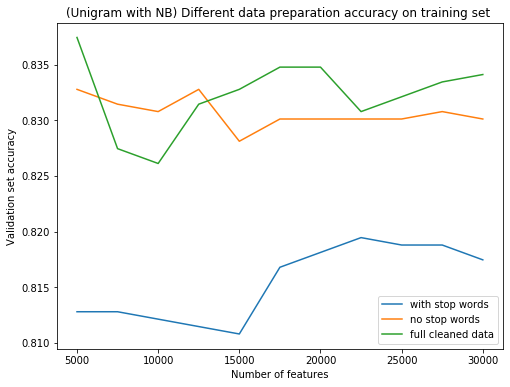

In [187]:
plt.figure(figsize=(8,6))
plt.plot(feat_tun_nochanges_nb_df.nfeatures,feat_tun_nochanges_nb_df.validation_accuracy,label = 'with stop words')
plt.plot(feat_tun_stop_words_nb_df.nfeatures,feat_tun_stop_words_nb_df.validation_accuracy,label = 'no stop words')
plt.plot(feat_tun_full_clean_nb_df.nfeatures,feat_tun_full_clean_nb_df.validation_accuracy,label = 'full cleaned data')
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.title("(Unigram with NB) Different data preparation accuracy on training set ")
plt.legend()

In case of NB, the accuracy is the highest for the full cleaned data. The results for data with stopwords are definitely worse. But the difference between cleaned data and data without stop words is not relevant. Thus, in further steps, we won't use full cleaning - it isn't worthwile.

In [188]:
feature_tune_bg_lr = nfeature_accuracy_checker(ngram_range=(1, 2),stop_words='english')
feature_tune_tg_lr = nfeature_accuracy_checker(ngram_range=(1, 3),stop_words='english')
feature_tune_fog_lr = nfeature_accuracy_checker(ngram_range=(1, 4),stop_words='english')
feature_tune_fig_lr = nfeature_accuracy_checker(ngram_range=(1, 5),stop_words='english')
feature_tune_sg_lr = nfeature_accuracy_checker(ngram_range=(1, 6),stop_words='english')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 



/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on test data 0.8427714856762158 

train and test time 6.950283050537109 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8414390406395736 

train and test time 6.456097841262817 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8467688207861426 

train and test time 21.80169701576233 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8494337108594271 

train and test time 26.253766775131226 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8507661558960693 

train and test time 13.523820161819458 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8520986009327115 

train and test time 13.686647891998291 
---------------------------------------------------------------------------

### Comparison of 1-6grams on the data without stopwords + logistic regression

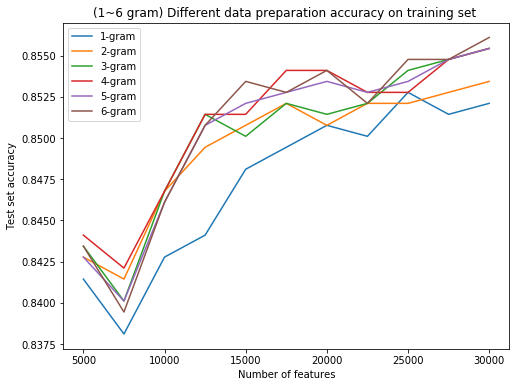

In [201]:
feature_tune_bg_lr_pd = pd.DataFrame(feature_tune_bg_lr,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_tg_lr_pd = pd.DataFrame(feature_tune_tg_lr,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_fog_lr_pd = pd.DataFrame(feature_tune_fog_lr,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_fig_lr_pd = pd.DataFrame(feature_tune_fig_lr,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_sg_lr_pd = pd.DataFrame(feature_tune_sg_lr,columns=['nfeatures','validation_accuracy','train_test_time'])


plt.figure(figsize=(8,6))
plt.plot(feat_tun_stop_words_df.nfeatures,feat_tun_stop_words_df.validation_accuracy,label = '1-gram')
plt.plot(feature_tune_bg_lr_pd.nfeatures,feature_tune_bg_lr_pd.validation_accuracy,label = '2-gram')
plt.plot(feature_tune_tg_lr_pd.nfeatures,feature_tune_tg_lr_pd.validation_accuracy,label = '3-gram')
plt.plot(feature_tune_fog_lr_pd.nfeatures,feature_tune_fog_lr_pd.validation_accuracy,label = '4-gram')
plt.plot(feature_tune_fig_lr_pd.nfeatures,feature_tune_fig_lr_pd.validation_accuracy,label = '5-gram')
plt.plot(feature_tune_sg_lr_pd.nfeatures,feature_tune_sg_lr_pd.validation_accuracy,label = '6-gram')
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.title("(1~6 gram) Different data preparation accuracy on training set ")
plt.legend()

It's clearly visible that there aren't big differences between the methods.

### Comparison of 1-6grams on the data without stopwords + Naive Bayes

In [191]:
feature_tune_bg_nb = nfeature_accuracy_checker(ngram_range=(1, 2),stop_words='english',classifier=nb)
feature_tune_tg_nb = nfeature_accuracy_checker(ngram_range=(1, 3),stop_words='english',classifier=nb)
feature_tune_fog_nb = nfeature_accuracy_checker(ngram_range=(1, 4),stop_words='english',classifier=nb)
feature_tune_fig_nb = nfeature_accuracy_checker(ngram_range=(1, 5),stop_words='english',classifier=nb)
feature_tune_sg_nb = nfeature_accuracy_checker(ngram_range=(1, 6),stop_words='english',classifier=nb)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

Accuracy on test data 0.8301132578281146 

train and test time 13.640237092971802 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8334443704197202 

train and test time 6.397201061248779 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8421052631578947 

train and test time 5.841168165206909 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8467688207861426 

train and test time 5.807719945907593 
-------------------------------------------------------------------------------------
Accuracy on test data 0.843437708194537 

train and test time 5.331519842147827 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8500999333777481 

train and test time 5.869563102722168 
-----------------

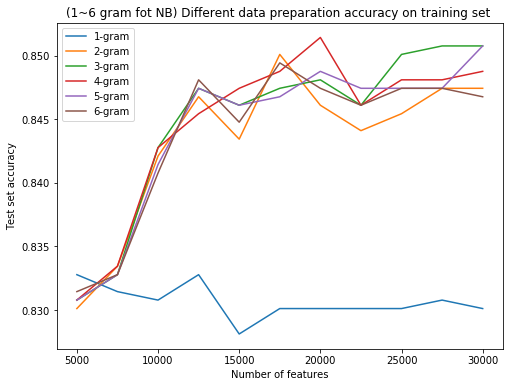

In [200]:
feature_tune_bg_nb_pd = pd.DataFrame(feature_tune_bg_nb,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_tg_nb_pd = pd.DataFrame(feature_tune_tg_nb,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_fog_nb_pd = pd.DataFrame(feature_tune_fog_nb,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_fig_nb_pd = pd.DataFrame(feature_tune_fig_nb,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_sg_nb_pd = pd.DataFrame(feature_tune_sg_nb,columns=['nfeatures','validation_accuracy','train_test_time'])


plt.figure(figsize=(8,6))
plt.plot(feat_tun_stop_words_nb_df.nfeatures,feat_tun_stop_words_nb_df.validation_accuracy,label = '1-gram')
plt.plot(feature_tune_bg_nb_pd.nfeatures,feature_tune_bg_nb_pd.validation_accuracy,label = '2-gram')
plt.plot(feature_tune_tg_nb_pd.nfeatures,feature_tune_tg_nb_pd.validation_accuracy,label = '3-gram')
plt.plot(feature_tune_fog_nb_pd.nfeatures,feature_tune_fog_nb_pd.validation_accuracy,label = '4-gram')
plt.plot(feature_tune_fig_nb_pd.nfeatures,feature_tune_fig_nb_pd.validation_accuracy,label = '5-gram')
plt.plot(feature_tune_sg_nb_pd.nfeatures,feature_tune_sg_nb_pd.validation_accuracy,label = '6-gram')
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.title("(1~6 gram fot NB) Different data preparation accuracy on training set ")
plt.legend()

This time, unigram has definitely worse results, but all the other methods look almost similar.

### Comparison of TFIDF and CountVectorizer (Logistic regression)

In [194]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfdf = TfidfVectorizer()

In [196]:
feature_tune_tf_ug  = nfeature_accuracy_checker(vectorizer = tfdf, stop_words='english')
feature_tune_tf_tg = nfeature_accuracy_checker(vectorizer = tfdf, stop_words='english',ngram_range = (1, 3))
feature_tune_tf_sg  = nfeature_accuracy_checker(vectorizer = tfdf, stop_words='english',ngram_range = (1, 6))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 



/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on test data 0.8540972684876749 

train and test time 4.523656129837036 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8527648234510327 

train and test time 2.7774877548217773 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8514323784143905 

train and test time 4.661809921264648 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8507661558960693 

train and test time 3.245629072189331 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8514323784143905 

train and test time 1.8927948474884033 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8540972684876749 

train and test time 1.8050730228424072 
---------------------------------------------------------------------------

In [197]:
feature_tune_tf_ug_pd = pd.DataFrame(feature_tune_tf_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_tf_tg_pd = pd.DataFrame(feature_tune_tf_tg ,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_tf_sg_pd = pd.DataFrame(feature_tune_tf_sg ,columns=['nfeatures','validation_accuracy','train_test_time'])

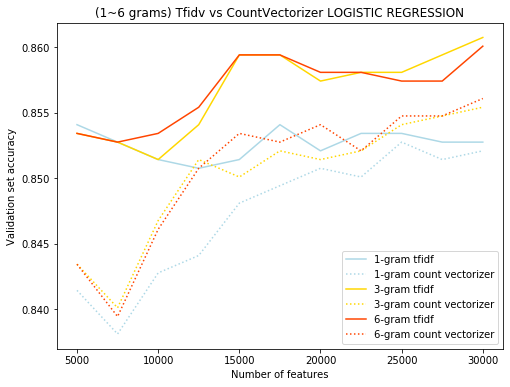

In [199]:
plt.figure(figsize=(8,6))
plt.plot(feature_tune_tf_ug_pd.nfeatures,feature_tune_tf_ug_pd.validation_accuracy,label='1-gram tfidf',color = 'lightblue')
plt.plot(feat_tun_stop_words_df.nfeatures,feat_tun_stop_words_df.validation_accuracy,label = '1-gram count vectorizer',linestyle = ':',color = 'lightblue')
plt.plot(feature_tune_tf_tg_pd.nfeatures,feature_tune_tf_tg_pd.validation_accuracy,label='3-gram tfidf',color = 'gold')
plt.plot(feature_tune_tg_lr_pd.nfeatures,feature_tune_tg_lr_pd.validation_accuracy,label = '3-gram count vectorizer',linestyle = ':',color = 'gold')
plt.plot(feature_tune_tf_sg_pd.nfeatures,feature_tune_tf_sg_pd.validation_accuracy,label='6-gram tfidf',color = 'orangered')
plt.plot(feature_tune_sg_lr_pd.nfeatures,feature_tune_sg_lr_pd.validation_accuracy,label = '6-gram count vectorizer',linestyle = ':',color = 'orangered')
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.title('(1~6 grams) Tfidv vs CountVectorizer LOGISTIC REGRESSION')
plt.legend()

Dotted plots are responding to TFIDF and line plots to CountVectorizer. Definitely, TFIDF works better on our dataset. Once again unigram has worse result, whereas 3-gram and 6-gram work the best.

### Comparison of TFIDF and CountVectorizer (Naive Bayes)

In [202]:

feature_tune_tf_ug_nb  = nfeature_accuracy_checker(vectorizer = tfdf ,stop_words='english',classifier=nb)
feature_tune_tf_tg_nb = nfeature_accuracy_checker(vectorizer = tfdf ,stop_words='english',ngram_range = (1, 3),classifier=nb)
feature_tune_tf_sg_nb  = nfeature_accuracy_checker(vectorizer = tfdf ,stop_words='english',ngram_range = (1, 6),classifier=nb)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

Accuracy on test data 0.8361092604930047 

train and test time 8.158468008041382 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8347768154563624 

train and test time 1.900519847869873 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8347768154563624 

train and test time 2.1385698318481445 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8314457028647568 

train and test time 1.68464994430542 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8361092604930047 

train and test time 1.7927343845367432 
-------------------------------------------------------------------------------------
Accuracy on test data 0.8354430379746836 

train and test time 1.8211188316345215 
---------------

In [203]:
feature_tune_tf_ug_nb_pd = pd.DataFrame(feature_tune_tf_ug_nb,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_tf_tg_nb_pd = pd.DataFrame(feature_tune_tf_tg_nb ,columns=['nfeatures','validation_accuracy','train_test_time'])
feature_tune_tf_sg_nb_pd = pd.DataFrame(feature_tune_tf_sg_nb ,columns=['nfeatures','validation_accuracy','train_test_time'])

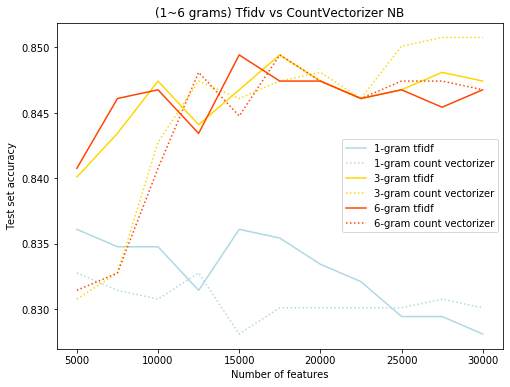

In [205]:
plt.figure(figsize=(8,6))
plt.plot(feature_tune_tf_ug_nb_pd.nfeatures,feature_tune_tf_ug_nb_pd.validation_accuracy,label='1-gram tfidf',color = 'lightblue')
plt.plot(feat_tun_stop_words_nb_df.nfeatures,feat_tun_stop_words_nb_df.validation_accuracy,label = '1-gram count vectorizer',linestyle = ':',color = 'lightblue')
plt.plot(feature_tune_tf_tg_nb_pd.nfeatures,feature_tune_tf_tg_nb_pd.validation_accuracy,label='3-gram tfidf',color = 'gold')
plt.plot(feature_tune_tg_nb_pd.nfeatures,feature_tune_tg_nb_pd.validation_accuracy,label = '3-gram count vectorizer',linestyle = ':',color = 'gold')
plt.plot(feature_tune_tf_sg_nb_pd.nfeatures,feature_tune_tf_sg_nb_pd.validation_accuracy,label='6-gram tfidf',color = 'orangered')
plt.plot(feature_tune_sg_nb_pd.nfeatures,feature_tune_sg_nb_pd.validation_accuracy,label = '6-gram count vectorizer',linestyle = ':',color = 'orangered')
plt.xlabel("Number of features")
plt.ylabel("Test set accuracy")
plt.title('(1~6 grams) Tfidf vs CountVectorizer NB')
plt.legend()

For the NB classifier, unigrams look definitely worse in both cases. All the other methods work almost the same. Thus, taking into account this plot and the previous one, we will only consider 3-gram TFIDF in the last step of our sentiment analysis.

## Different methods for sentiment classification 

In [208]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer

In [217]:
names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]

classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
    
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()

In [218]:
def cls_compare(vectorizer=tvec, n_features=30000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print(f"Validation result for {n}")
        print(c)
        clf_accuracy,tt_time = accuracy(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,clf_accuracy,tt_time))
    return result

In [219]:
cls_outcome = cls_compare(stop_words = 'english',ngram_range=(1, 3))
cls_imdb_score = pd.DataFrame(cls_outcome,columns = ['model','test accuracy','time'])

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on test data 0.8607594936708861 

train and test time 11.535930871963501 
-------------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Accuracy on test data 0.8734177215189873 

train and test time 10.448095798492432 
-------------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
        max_features=None, n...ax_iter=1000,
     m

/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Accuracy on test data 0.844103930712858 

train and test time 9.147571802139282 
-------------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)


/Users/czoppson/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Accuracy on test data 0.8620919387075283 

train and test time 8.73842978477478 
-------------------------------------------------------------------------------------
Validation result for Nearest Centroid
NearestCentroid(metric='euclidean', shrink_threshold=None)
Accuracy on test data 0.8014656895403065 

train and test time 8.799280881881714 
-------------------------------------------------------------------------------------


In [220]:
cls_imdb_score

model  test accuracy       time
0                        Logistic Regression       0.860759  11.535931
1                                 Linear SVC       0.873418  10.448096
2  LinearSVC with L1-based feature selection       0.852099  10.025552
3                             Multinomial NB       0.847435   9.510266
4                               Bernoulli NB       0.852099   9.396116
5                           Ridge Classifier       0.868088   9.497232
6                                   AdaBoost       0.768821  13.894340
7                                 Perceptron       0.844104   9.147572
8                          Passive-Aggresive       0.862092   8.738430
9                           Nearest Centroid       0.801466   8.799281